In [112]:
import numpy as np

def FMO_formular(Cr, T=673.15, t = 600, DOC = 10):
    """
    Cao B, Yang S, Sun A, Dong Z, Zhang TY. 
    Domain knowledge-guided interpretive machine learning: 
    formula discovery for the oxidation behavior of ferritic-martensitic 
    steels in supercritical water. J Mater Inf 2022;2:4. 
    http://dx.doi.org/10.20517/jmi.2022.04
    
    input:
    Cr : oxidation chromium equivalent concentration (wt.%), 10.38 <= Cr <= 30.319
    Cr(wt.%) = [Cr](wt.%) + 40.3[V](wt.%) + 2.3[Si](wt.%) + 10.7[Ni](wt.%) − 1.5[Mn](wt.%)
    T : Absolute temperature (K), 673.15 <= T <= 923.15
    t : Exposure time (h), 30 <= t <= 2000
    DOC : Dissolved oxygen concentration (ppb), 0 <= DOC <= 8000
    
    output:
    the logarithm of weight gain (mg / dm2)
    """
    # Eq.(6c) in paper
    pre_factor = 0.084*(Cr**3/(T-DOC) - np.sqrt(T+DOC)) + 0.98*(Cr-DOC/T) / np.log(Cr+DOC)+8.543
    
    # Eq.(5a) in paper
    Q = 0.084*(Cr**2-Cr+DOC) / np.exp(DOC/T) + 45.09
    
    # Eq.(5b) in paper
    m = 0.323 - 0.061 * np.exp(DOC/T) / (Cr - np.sqrt(Cr) - DOC)
    
    ln_wg = pre_factor + np.log(DOC+2.17) -  Q * 1000 / 8.314 / T + m*np.log(t)
    
    return ln_wg

# generate data

In [344]:
import random

random.seed(42)  

source = []

while len(source) < 20:
    random_number = random.uniform(16, 18)
    if random_number not in source:
        formatted_number = round(random_number,2)
        source.append(formatted_number)
    source.sort()


In [345]:
random.seed(42) 

target = []

while len(target) < 20:
    random_number = random.uniform(14, 16)
    if random_number not in target:
        formatted_number = round(random_number,2)
        target.append(formatted_number)

        
random.shuffle(target)  

target_test = target[:10]

target_train = target[10:]


In [346]:
target_test

[15.3, 14.44, 15.28, 14.17, 15.09, 14.55, 14.06, 15.62, 15.18, 15.78]

# cal labels

In [347]:
Ys = FMO_formular(np.array(source))
Ys 

array([4.28762677, 4.286294  , 4.286294  , 4.28593767, 4.28143797,
       4.26893795, 4.26638147, 4.26638147, 4.26572593, 4.25882298,
       4.23554565, 4.21990128, 4.21207914, 4.20294762, 4.19240738,
       4.19025115, 4.18479209, 4.17130182, 4.1537004 , 4.13406903])

In [348]:
Yt_train = FMO_formular(np.array(target_train))
Yt_test =  FMO_formular(np.array(target_test))

In [349]:
Yt_train

array([4.24272342, 3.36021514, 3.19273477, 3.36021514, 4.03106003,
       4.28734686, 4.2064398 , 4.02360696, 3.99139946, 4.28104791])

In [350]:
Yt_test

array([4.27749602, 4.02360696, 4.27590592, 3.68779915, 4.25514913,
       4.09472442, 3.39613599, 4.29146826, 4.2663516 , 4.29211302])

In [351]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score

reg = SVR()
pre_y = reg.fit(np.array(target_train).reshape(-1,1), np.array(Yt_train).reshape(-1,1)).predict(np.array(target_test).reshape(-1,1))

In [352]:
pre_y

array([4.18576581, 3.94809518, 4.1829754 , 3.49824255, 4.15066715,
       4.06404803, 3.3412569 , 4.14761249, 4.16565155, 4.07096998])

In [353]:
r2_score(Yt_test,pre_y)

0.8211324687124604

#  LOOCV test on target domain training data 

In [461]:
from sklearn.model_selection import LeaveOneOut
import warnings
warnings.filterwarnings("ignore")

test_R2 = []
LOOCV_R2 = []
_range = np.linspace(.001, .2, 60)
for lamda in _range:
    loo = LeaveOneOut()
    X = np.array(target_train)
    Y = Yt_train 
    pre_list = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]

        rse = TCA_reg(source,Ys,X_train,y_train,X_test,y_test,SVR(),lamda)
        pre_list.append(rse[0])
        
    LOOCV_R2.append(r2_score(Yt_train,pre_list))
    
    test_res = TCA_reg(source,Ys,target_train,Yt_train,target_test,Yt_test,SVR(),lamda)
    test_R2.append(r2_score(Yt_test,test_res))
    

0.9186273453562954
0.8884890347252081


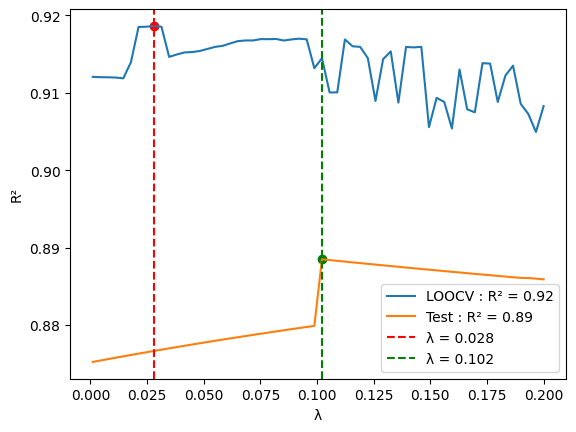

In [472]:
plot_lists(LOOCV_R2,test_R2,_range)

In [471]:
import numpy as np
import matplotlib.pyplot as plt

def plot_lists(A, B, C):
    max_index_A = np.argmax(A)
    max_value_A = A[max_index_A]
    print(max_value_A)

    max_index_B = np.argmax(B)
    max_value_B = B[max_index_B]
    print(max_value_B)

    plt.plot(C, A, label='LOOCV : R\u00B2 = 0.92',)
    plt.plot(C, B, label='Test : R\u00B2 = 0.89', )

    plt.axvline(x=C[max_index_A], linestyle='--', color='r', label='\u03BB = {}'.format(round(C[max_index_A],3)))
    plt.axvline(x=C[max_index_B], linestyle='--', color='g', label='\u03BB = {}'.format(round(C[max_index_B],3)))

    plt.scatter(C[max_index_A], max_value_A, color='r')
    plt.scatter(C[max_index_B], max_value_B, color='g')
    
    # plt.ylim(0, 1) 
    plt.xlabel('\u03BB')
    plt.ylabel('R\u00B2')
    plt.legend()
    plt.savefig('FMO.png',bbox_inches = 'tight',dpi=600)
    plt.savefig('FMO.svg',bbox_inches = 'tight',dpi=600)
    plt.show()


In [382]:
def TCA_reg(Xs,Ys,Xt,Yt,Tx,Ty,reg,lamda=1):
    # for our example
    # Xs : features of source domian data
    # Ys : response of source domian data
    # Xt : features of target domian data
    # Yt : response of target domian data
    # Tx : features of test data
    # Ty : response of test data
    # test and target are defined in same target domain.
    # reg : Machine Learning model
    
    Xs = np.array(Xs).reshape(-1,1)
    Ys = np.array(Ys).reshape(-1,1)
    Xt = np.array(Xt).reshape(-1,1)
    Yt = np.array(Yt).reshape(-1,1)
    Tx = np.array(Tx).reshape(-1,1)
    Ty = np.array(Ty).reshape(-1,1)
    
    Xtrain = np.concatenate((Xs, Xt))
    Ytrain = np.concatenate((Ys, Yt))
    
    # TCA
    new_Xtrain, new_Tx = TCA(dim=2, lamda=lamda, gamma=1.5).fit(Xtrain, Tx)
    
    # reg 
    pre = reg.fit(new_Xtrain,Ytrain).predict(new_Tx)

    return pre

---

In [218]:
import numpy as np
import scipy.linalg
from sklearn.gaussian_process.kernels import  RBF 

class TCA():
    def __init__(self, dim=30, lamda=1, gamma=1):
        '''
        :param dim: data dimension after projection
        :param lamb: lambda value, Lagrange multiplier
        :param gamma: length scale for rbf kernel
        '''
        self.dim = dim
        self.lamda = lamda
        self.kernel = 0.5*RBF(gamma,"fixed")

    def fit(self, Xs, Xt, ):
        '''
        :param Xs: ns * m_feature, source domain data 
        :param Xt: nt * m_feature, target domain data
        Projecting Xs and Xt to a lower dimension by TCA
        source/target domain data expressed in a mapping space
        :return: Xs_new and Xt_new 
        '''
        # formular in paper Domain Adaptation via Transfer Component Analysis
        # Eq.(2) 
        X = np.vstack((Xs, Xt))
        K = self.kernel(X)
        # cal matrix L 
        ns, nt = len(Xs), len(Xt)
        if self.dim > (ns + nt):
            raise DimensionError('The maximum number of dimensions should be smaller than', (ns + nt))
        else:pass
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        L = e * e.T
        # cal centering matrix H page 202 the last pargraph at left side
        n, _ = X.shape
        H = np.eye(n) - 1 / n * np.ones((n, n))
        # page 202 the last pargraph at right side
        matrix = (K @ L @ K + self.lamda * np.eye(n)) @ K @ H @ K.T
        # cal eigenvalues : w, eigenvectors :V
        w, V = scipy.linalg.eig(matrix)
        w, V = w.real, V.real
        # peak out the first self.dim components
        ind = np.argsort(abs(w))[::-1]
        A = V[:, ind[:self.dim]]
        # output the mapped data
        Z = K @ A
        Xs_new, Xt_new = Z[:ns, :], Z[ns:, :]
        return Xs_new, Xt_new


class DimensionError(Exception):
    pass